In [ ]:
%pip install classy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for classy: filename=classy-3.3.0.0-cp311-cp311-linux_x86_64.whl size=11977923 sha256=d5ffc8760d48dca3e3be5ca3e75ffccd01029d869219c740a74fd92022692944
  Stored in directory: /root/.cache/pip/wheels/98/b8/29/4fc545f931b5f16fca92543b997f87f87da8ce584f067ea8d7
Successfully built classy


In [ ]:
# Imports
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import quad
from astropy.cosmology import Planck18
from classy import Class


In [ ]:
# Background & growth
class Background:
    def __init__(self, cosmo=Planck18):
        self.cosmo=cosmo
        self.h=cosmo.h; self.H0=cosmo.H0
        self.Om0=cosmo.Om0; self.Ode0=cosmo.Ode0
    def Hratio(self,a):
        return np.sqrt(self.Om0 * a**(-3) + self.Ode0)

bg=Background()
print(bg.h, bg.H0, bg.Om0, )

0.6766 67.66 km / (Mpc s) 0.30966


In [ ]:
# Growth factor D(a) (normalised to unity today)
def D_of_a(a,bg=bg,a_min=1e-5):
    def integrand(a_):
        num=1
        den=bg.Om0*a_**-1+bg.Ode0*a_**2
        return num/den
    I1,_=quad(integrand,a_min,1.0)
    Ia,_=quad(integrand,a_min,a)
    return Ia/I1*Hratio(a)


In [ ]:
# CLASS run: need both P(k,z) and T_m(k,0)
h=bg.h
z_target=1.0
kmin,kmax,nk=1e-4,10.0,640
k_h=np.logspace(np.log10(kmin),np.log10(kmax),nk)     # h/Mpc
k_phys=k_h*h

params={'h':h,
        'omega_b':0.0223828,
        'omega_cdm':0.1201075,
        'A_s':2.100549e-9,
        'n_s':0.96605,
        'tau_reio':0.0543,
        'output':'mPk,mTk',
        'z_max_pk':z_target,
        'P_k_max_1/Mpc':kmax/h*1.1}

cosmo=Class(); cosmo.set(params); cosmo.compute()

P_class=np.array([cosmo.pk(k,z_target) for k in k_phys])

tr0=cosmo.get_transfer(0.0)
k_tr_phys=np.array(tr0['k (h/Mpc)'])*h
T_m0_full=np.array(tr0['d_m'])
T_m0=np.interp(k_phys,k_tr_phys,T_m0_full)

A_s=params['A_s']; n_s=params['n_s']; k_piv=0.05   # 1/Mpc
D_z=D_of_a(1/(1+z_target))
P_analytic=(2*np.pi**2/k_phys**3)*A_s*(k_phys/k_piv)**(n_s-1)*T_m0**2*D_z**2


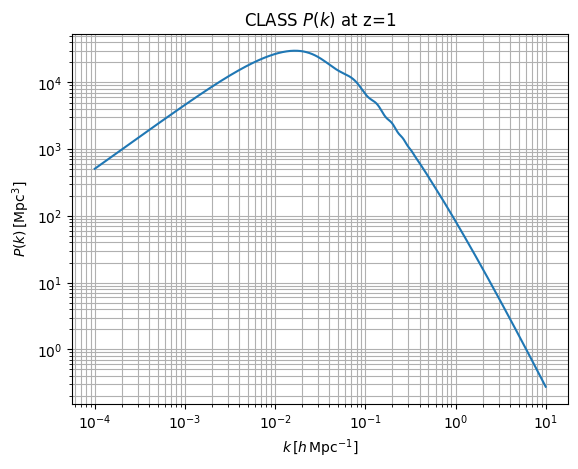

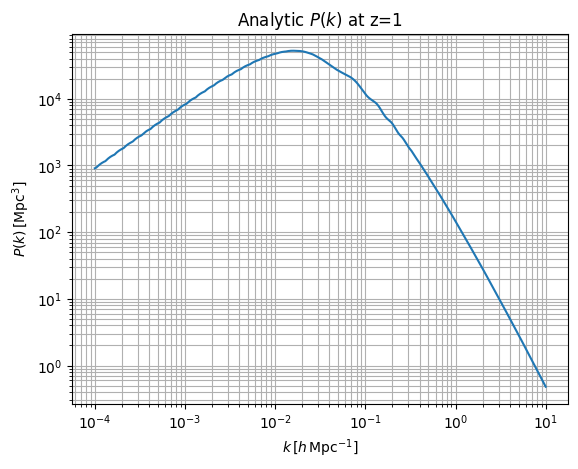

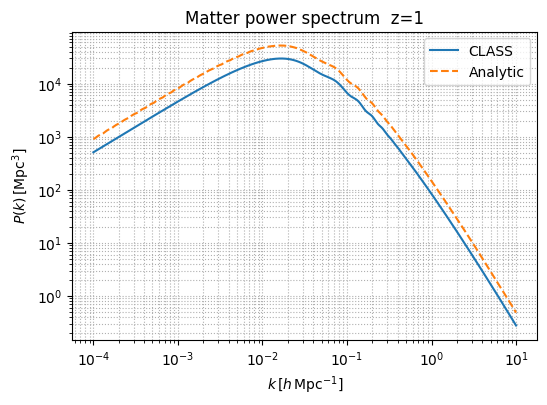

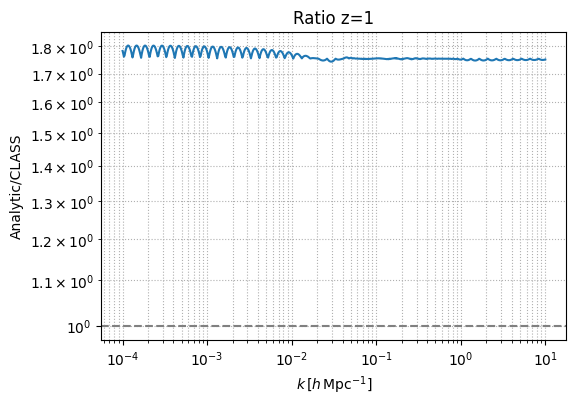

In [ ]:
# Plot spectra and ratio
plt.loglog(k_h,P_class)
plt.xlabel('$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel('$P(k)\,[\mathrm{Mpc}^3]$')
plt.title('CLASS $P(k)$ at z=1')
plt.grid(True,which='both')
plt.show()


plt.loglog(k_h,P_analytic,label='CLASS')
plt.xlabel('$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel('$P(k)\,[\mathrm{Mpc}^3]$')
plt.title('Analytic $P(k)$ at z=1')
plt.grid(True,which='both')
plt.show()

plt.figure(figsize=(6,4))
plt.loglog(k_h,P_class,label='CLASS')
plt.loglog(k_h,P_analytic,'--',label='Analytic')
plt.xlabel('$k\,[h\,\mathrm{Mpc}^{-1}]$')
plt.ylabel('$P(k)\,[\mathrm{Mpc}^3]$')
plt.legend(); plt.grid(True,which='both',ls=':')
plt.title('Matter power spectrum  z=1')
plt.show()

ratio=P_analytic/P_class
plt.figure(figsize=(6,4))
plt.loglog(k_h,ratio)
plt.axhline(1,color='gray',ls='--')
plt.xlabel('$k\,[h\,\mathrm{Mpc}^{-1}]$'); plt.ylabel('Analytic/CLASS')
plt.title('Ratio z=1')
plt.grid(True,which='both',ls=':')
plt.show()
